**Importing Libraries**

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Bidirectional, Dense, Embedding, Layer, Input, dot, Activation, concatenate, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

**Downloading Dataset**

In [2]:
(train_data, test_data), info = tfds.load('imdb_reviews', split=(tfds.Split.TRAIN, tfds.Split.TEST), as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.74482V_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.74482V_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.74482V_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


**Preprocessing data**

In [3]:
def preprocess_text(text, label):
    text = tf.strings.regex_replace(text, rb"<br\s*/>", b" ")
    text = tf.strings.regex_replace(text, b"[^a-zA-Z']", b" ")
    return text, label

In [4]:
train_data = train_data.map(preprocess_text)
test_data = test_data.map(preprocess_text)

In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 10000, oov_token = '<OOV>')
train_sentences = [x.numpy().decode('utf-8') for x,y in train_data]
tokenizer.fit_on_texts(train_sentences)

In [6]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen = 120, padding = 'post', truncating = 'post')

In [7]:
test_sentences = [x.numpy().decode('utf-8') for x,y in test_data]
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen = 120, padding = 'post', truncating = 'post')

In [8]:
train_labels = [y.numpy() for x,y in train_data]
test_labels = [y.numpy() for x,y in test_data]

train_padded = tf.convert_to_tensor(train_padded)
test_padded = tf.convert_to_tensor(test_padded)
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)

**Model 1 - Using Bidirectional RNN**

In [9]:
bidirectionalRnnModel = Sequential()
bidirectionalRnnModel.add(Embedding(input_dim = 10000, output_dim= 64, input_length = 120))
bidirectionalRnnModel.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
bidirectionalRnnModel.add(Bidirectional(SimpleRNN(32)))
bidirectionalRnnModel.add(Dense(1, activation = 'sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
bidirectionalRnnModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
bidirectionalRnnModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 120, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 120, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 666,881 (2.54 MB)

 Trainable params: 666,881 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
bidirectionalRnnModel.fit(train_padded, train_labels, epochs = 5, validation_data = (test_padded, test_labels), batch_size = 64)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 95ms/step - accuracy: 0.5129 - loss: 0.7003 - val_accuracy: 0.5870 - val_loss: 0.6661
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.7273 - loss: 0.5421 - val_accuracy: 0.7896 - val_loss: 0.4960
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.8954 - loss: 0.2628 - val_accuracy: 0.7664 - val_loss: 0.5712
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - accuracy: 0.9473 - loss: 0.1385 - val_accuracy: 0.6829 - val_loss: 0.9427
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - accuracy: 0.9773 - loss: 0.0669 - val_accuracy: 0.6859 - val_loss: 0.9864


In [29]:
bi_loss, bi_accuracy = bidirectionalRnnModel.evaluate(test_padded, test_labels)
print(f'Loss: {bi_loss}, Accuracy: {bi_accuracy}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.6918 - loss: 0.9719
Loss: 0.9864323735237122, Accuracy: 0.685920000076294


**Model 2: Using Attention with Unidirectional RNN**

In [13]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name = 'att_weight', shape = (input_shape[-1], input_shape[-1]), initializer = 'random_normal', trainable = True)
        self.b = self.add_weight(name = 'att_bias', shape = (input_shape[-1],), initializer = 'zeros', trainable = True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, hidden_states):
        score_first_part = tf.keras.backend.dot(hidden_states, self.W)
        score_first_part = tf.keras.backend.bias_add(score_first_part, self.b)
        score = tf.keras.backend.tanh(score_first_part)
        attention_weights = tf.keras.backend.softmax(score, axis = 1)
        context_vector = attention_weights * hidden_states
        context_vector = tf.keras.backend.sum(context_vector, axis = 1)
        return context_vector

In [14]:
input_shape = (120,)
rnn_input = Input(shape = input_shape)
x = Embedding(input_dim = 10000, output_dim= 64, input_length = 120)(rnn_input)
rnn_output = SimpleRNN(64, return_sequences=True)(x)
attention_output = AttentionLayer()(rnn_output)
output = Dense(1, activation = 'sigmoid')(attention_output)

In [15]:
attentionRnn = Model(inputs = rnn_input, outputs = output)
attentionRnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
attentionRnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 120, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 120, 64)             │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 652,481 (2.49 MB)

 Trainable params: 652,481 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
attentionRnn.fit(train_padded, train_labels, epochs = 5, validation_data = (test_padded, test_labels), batch_size = 64)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.6920 - loss: 0.5727 - val_accuracy: 0.8151 - val_loss: 0.4058
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.8783 - loss: 0.3005 - val_accuracy: 0.8233 - val_loss: 0.4009
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9100 - loss: 0.2378 - val_accuracy: 0.8190 - val_loss: 0.4206
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9227 - loss: 0.2062 - val_accuracy: 0.8121 - val_loss: 0.4821
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9394 - loss: 0.1669 - val_accuracy: 0.8090 - val_loss: 0.4952


In [32]:
attention_loss, attention_accuracy = attentionRnn.evaluate(test_padded, test_labels)
print(f'Loss: {attention_loss}, Accuracy: {attention_accuracy}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8091 - loss: 0.4937
Loss: 0.4952276945114136, Accuracy: 0.8089600205421448


**Model 3: Using Bidrectional RNN with Attention**

In [24]:
rnn_input = Input(shape = input_shape)
x = Embedding(input_dim = 10000, output_dim= 64, input_length = 120)(rnn_input)
rnn_output = Bidirectional(SimpleRNN(64, return_sequences=True))(x)
bi_attention_rnn_output = Bidirectional(SimpleRNN(32, return_sequences= True))(rnn_output)
attention_output = AttentionLayer()(bi_attention_rnn_output)
output = Dense(1, activation = 'sigmoid')(attention_output)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
biAttentionRnn = Model(inputs = rnn_input, outputs = output)
biAttentionRnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
biAttentionRnn.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ (None, 120, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 120, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 120, 64)             │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_6 (AttentionLayer)   │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 671,041 (2.56 MB)

 Trainable params: 671,041 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
biAttentionRnn.fit(train_padded, train_labels, epochs = 5, validation_data = (test_padded, test_labels), batch_size = 64)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 117ms/step - accuracy: 0.7022 - loss: 0.5381 - val_accuracy: 0.8248 - val_loss: 0.3885
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 115ms/step - accuracy: 0.8825 - loss: 0.2861 - val_accuracy: 0.8273 - val_loss: 0.3971
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 113ms/step - accuracy: 0.9125 - loss: 0.2189 - val_accuracy: 0.8100 - val_loss: 0.4410
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 113ms/step - accuracy: 0.9353 - loss: 0.1685 - val_accuracy: 0.8217 - val_loss: 0.4591
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 116ms/step - accuracy: 0.9572 - loss: 0.1146 - val_accuracy: 0.8120 - val_loss: 0.5777


In [31]:
bi_attention_loss, bi_attention_accuracy = biAttentionRnn.evaluate(test_padded, test_labels)
print(f'Loss: {bi_attention_loss}, Accuracy: {bi_attention_accuracy}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.8139 - loss: 0.5817
Loss: 0.5776835680007935, Accuracy: 0.8120399713516235


**Comparing Models**

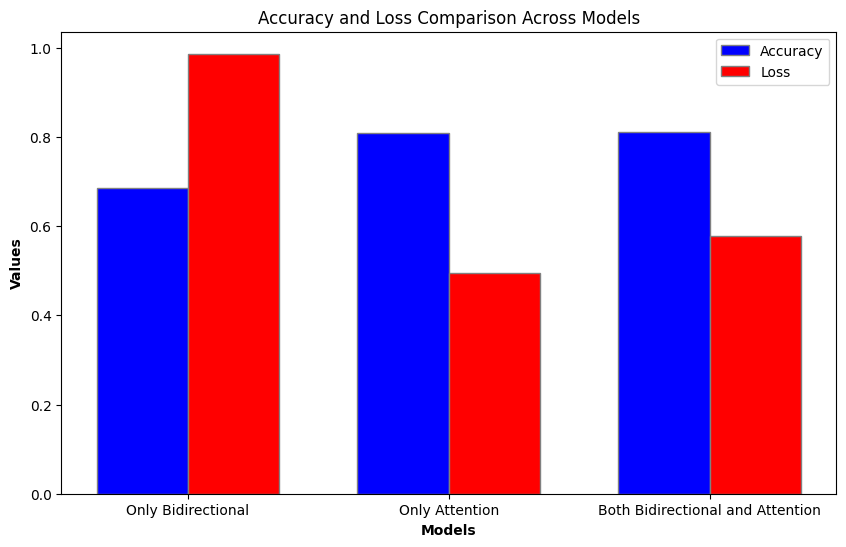

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Sample accuracy and loss values from 3 models
models = ['Only Bidirectional', 'Only Attention', 'Both Bidirectional and Attention']
accuracy_values = [bi_accuracy, attention_accuracy, bi_attention_accuracy]
loss_values = [bi_loss, attention_loss, bi_attention_loss]

# Set width of the bars
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Create bar plots for accuracy and loss
plt.figure(figsize=(10, 6))

# Bar plot for accuracy
plt.bar(r1, accuracy_values, color='blue', width=bar_width, edgecolor='grey', label='Accuracy')

# Bar plot for loss
plt.bar(r2, loss_values, color='red', width=bar_width, edgecolor='grey', label='Loss')

# Add labels and title
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.ylabel('Values', fontweight='bold')
plt.title('Accuracy and Loss Comparison Across Models')

# Add legend
plt.legend()

# Show the plot
plt.show()